In [1]:
# 将谷歌硬盘安装到CoLab虚拟机上
# from google.colab import drive
# drive.mount('/content/drive')

# TODO:在驱动器中输入保存解压缩文件的文件夹名
# 工作分配文件夹, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# 现在我们已经安装了您的驱动器，这确保了Python解释器可以从中加载Python文件。
import sys
sys.path.append('D:/CodeWorkspace/{}'.format(FOLDERNAME))

# 这会将CIFAR-10数据集下载到您的驱动器（如果它还不存在）。
%cd D:/CodeWorkspace/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd D:/CodeWorkspace/$FOLDERNAME

D:\CodeWorkspace\cs231n\assignments\assignment1\cs231n\datasets
�(u�N  L i n u x   �v  W i n d o w s   P[�|�~�l	g�]�[ň�vR�SHr0
 
 
 �S�N�Ǐ���  M i c r o s o f t   S t o r e   eg�[ňR�SHr: 
 
 
 h t t p s : / / a k a . m s / w s l s t o r e 
 
 
 
D:\CodeWorkspace\cs231n\assignments\assignment1


# 多类支持向量机练习

*完成并提交此已完成的工作表（包括其输出和工作表之外的任何支持代码）和作业提交。有关详细信息，请参阅课程网站上的[作业页面](http://vision.stanford.edu/teaching/cs231n/assignments.html)*

在本练习中，您将：
    
- 为 SVM 实现完全矢量化的**损失函数**
- 实现其**分析梯度**的完全矢量化表达式
- 使用数值梯度**检查您的实现**
- 使用验证集**调整学习率和正则化强度**
- 使用 **SGD 优化**损失函数
- **可视化**最终学习的权重


In [3]:
# 为此笔记本运行一些安装代码。
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# 这有点神奇，可以使matplotlib图形在线显示在#笔记本中，而不是新窗口中。
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 一些更神奇的功能，使笔记本电脑能够重新加载外部python模块
# 参阅 http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 数据加载与预处理

In [4]:
# 加载原始CIFAR-10数据。
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# 清理变量以防止多次加载数据（这可能会导致内存问题）
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 作为健全性检查，我们打印出训练和测试数据的大小。
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


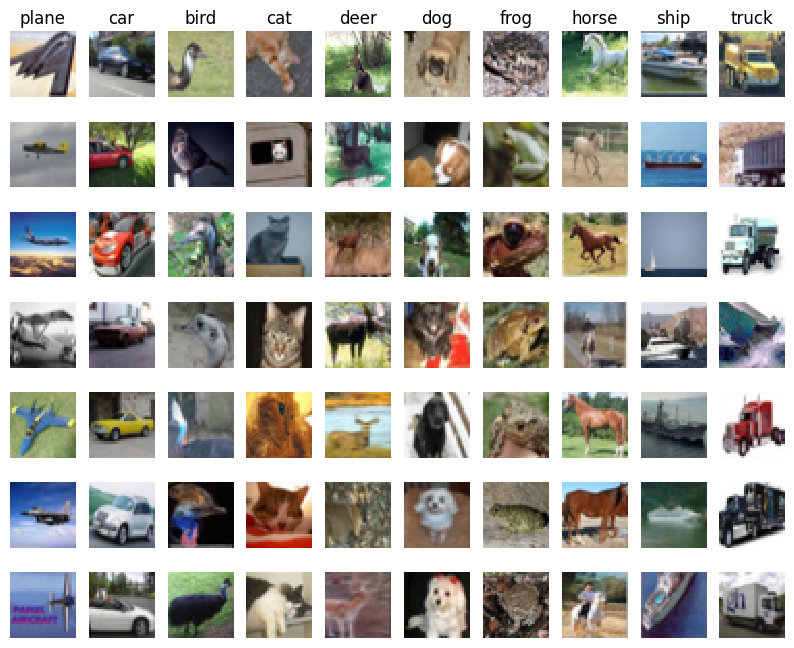

In [5]:
# 将数据集中的一些示例可视化。
# 展示了每个类别的一些训练图像示例。
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
# 遍历每个类别并显示其中的一部分样本
for y, cls in enumerate(classes):
    # 找到训练集中属于当前类别的样本的索引
    idxs = np.flatnonzero(y_train == y) # flatnonzero返回布尔数组中非零元素（True）的索引
    # 从索引中随机选择不重复的样本数量
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    # 遍历选择的索引并显示图像
    for i, idx in enumerate(idxs):
        # 遍历选择的索引并显示图像
        plt_idx = i * num_classes + y + 1
        # 为每个图像创建一个子图
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        # 为每个图像创建一个子图
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# 将数据拆分为训练集、val集和测试集。
# 此外，我们将创建一个小的开发集作为训练数据的子集；我们可以使用它进行开发，这样我们的代码运行得更快。
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# 我们的验证集将是来自原始训练集的num_validation点。
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# 我们的训练集将是原始训练集的第一个num_train点。
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# 我们还将制作一个开发集，它是训练集的一个子集。
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# 我们使用原始测试集的第一个num_test点作为我们的测试集。
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# 预处理：将图像数据重塑为行
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# 作为健全性检查，打印出数据的形状
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


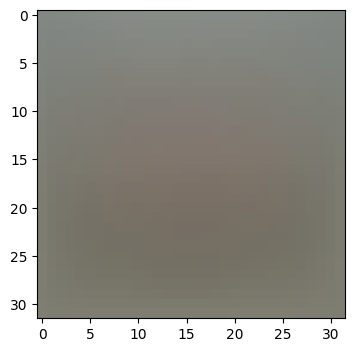

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [8]:
# 预处理：减去均值图像
# 第一：根据训练数据计算图像均值
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # 打印一些元素
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # 将平均图像可视化
plt.show()

# 第二：从训练和测试数据中减去平均图像
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# 第三：附加1的偏差维度（即偏差技巧），使得我们的SVM只需要考虑优化单个权重矩阵W，而不需要考虑pian'zhi。
# np.hstack()用于水平堆叠两个np数组
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM 分类器

本节的代码将全部编写在 `cs231n/classifiers/linear_svm.py`.

如您所见，我们预填充了使用 for 循环来评估多类 SVM 损失函数的函数 `svm_loss_naive` 

In [9]:
# 评估我们为您提供的损失的天真实施情况：
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# 随机生成一个小数字的随机SVM权重矩阵
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
# print(grad.shape)
# print(grad)
print('loss: %f' % (loss, ))

loss: 8.949457


从上面的函数返回的 `grad` 现在全部为零。派生并实现 SVM 成本函数的梯度，并在函数 `svm_loss_naive` 内联实现它。您会发现在现有函数中交错新代码很有帮助。

要检查是否正确实现了梯度，可以数值估计损失函数的梯度，并将数值估计值与计算的梯度进行比较。我们提供了执行此操作的代码：

In [10]:
# 一旦你实现了梯度，用下面的代码重新计算它，并用我们为你提供的函数进行梯度检查

# 计算W处的损耗及其梯度。
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# 用数字计算沿几个随机选择的维度的梯度，并将它们与分析计算的梯度进行比较。在所有维度上，数字应该几乎完全匹配。
from cs231n.gradient_check import grad_check_sparse # 导入梯度检查的函数 
# 定义一个 lambda 函数 f，它接受权重矩阵 w 作为参数，并返回损失值。这个函数用于数值梯度检查。
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
# 使用数值梯度检查，计算通过数值方法得到的梯度grad_numerical。这个函数会检查模型的数值梯度和解析梯度是否匹配。
grad_numerical = grad_check_sparse(f, W, grad)

# 再次调用 svm_loss_naive 函数，但这次使用了正则化强度 5e1。然后，再次进行数值梯度检查，确保在正则化开启的情况下梯度仍然正确计算。
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 17.948755 analytic: 17.948755, relative error: 2.178588e-12
numerical: -16.224389 analytic: -16.224389, relative error: 3.712151e-12
numerical: 39.224267 analytic: 39.224267, relative error: 1.608329e-12
numerical: 3.902506 analytic: 3.902506, relative error: 9.541365e-11
numerical: 8.766801 analytic: 8.719431, relative error: 2.708991e-03
numerical: 21.111893 analytic: 21.111893, relative error: 2.013338e-11
numerical: -30.926348 analytic: -30.926348, relative error: 2.536303e-12
numerical: 8.752525 analytic: 8.734966, relative error: 1.004090e-03
numerical: -3.509830 analytic: -3.509830, relative error: 1.597327e-10
numerical: -30.791332 analytic: -30.791332, relative error: 6.929915e-12
numerical: -9.118191 analytic: -9.118191, relative error: 4.083870e-11
numerical: 51.365509 analytic: 51.450751, relative error: 8.290705e-04
numerical: -36.124710 analytic: -36.124710, relative error: 4.122361e-12
numerical: -0.143991 analytic: -0.165644, relative error: 6.993076e-02
nume

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [11]:
# 接下来实现函数svm_loss_vectorized；现在只计算损失；我们稍后将实现梯度。
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 损失应该匹配，但矢量化的实现应该更快。
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.949457e+00 computed in 0.074698s
Vectorized loss: 8.949457e+00 computed in 0.000000s
difference: -0.000000


In [12]:
# 完成svm_loss_vectorized的实现，并以矢量化的方式计算损失函数的梯度。

# 天真的实现和向量化的实现应该匹配，但向量化的版本仍然应该快得多。
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# 损失是一个单独的数字，因此很容易比较两个实现计算的值。另一方面，梯度是一个矩阵，所以我们使用Frobenius范数来比较它们。
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.072009s
Vectorized loss and gradient: computed in 0.000000s
difference: 0.000000


### 随机梯度下降法(SGD)

我们现在有了损耗的矢量化和有效表达式，梯度和我们的梯度与数值梯度匹配。因此，我们准备进行SGD，以最大限度地减少损失。此部分的代码将写在`cs231n/classifiers/linear_classifier.py`.

In [13]:
# 在文件linear_classifier.py中，在函数LinearClassifier.train（）中实现SGD，然后用下面的代码运行它。
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 793.150316
iteration 100 / 1500: loss 287.538094
iteration 200 / 1500: loss 107.757637
iteration 300 / 1500: loss 42.738528
iteration 400 / 1500: loss 18.906711
iteration 500 / 1500: loss 10.059801
iteration 600 / 1500: loss 7.051076
iteration 700 / 1500: loss 6.272947
iteration 800 / 1500: loss 5.664908
iteration 900 / 1500: loss 4.706894
iteration 1000 / 1500: loss 5.600203
iteration 1100 / 1500: loss 5.085713
iteration 1200 / 1500: loss 5.176202
iteration 1300 / 1500: loss 5.809333
iteration 1400 / 1500: loss 5.476596
That took 2.324705s


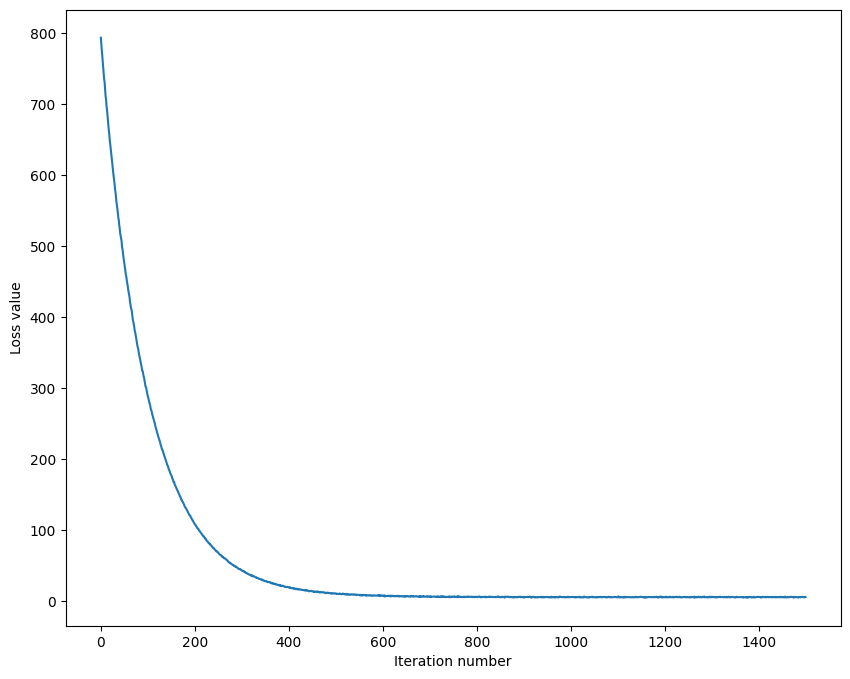

In [14]:
# 一个有用的调试策略是将损失绘制为迭代次数的函数：
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# 编写LinearSVM.predict函数，并评估训练集和验证集的性能
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369714
validation accuracy: 0.387000


In [16]:
# 使用验证集来调整超参数（正则化强度和学习率）。
# 你应该在不同的学习率和正则化强度范围内进行实验；如果你小心的话，你应该能够在验证集上获得大约0.39（＞0.385）的分类准确度。

# 注意：在超参数搜索过程中，您可能会看到运行时/溢出警告。
# 这可能是由极值引起的，并不是一个错误。

# 结果是将形式（learning_rate，regularization_strength）的元组字典映射到形式（training_precision，validation_preccision）的元组。
# 准确度只是正确分类的数据点的分数。
results = {} # 用于存储每个超参数组合的训练和验证准确度
best_val = -1   # 这是迄今为止我们所看到的最高的验证准确性。
best_svm = None # 实现最高验证率的LinearSVM对象。

################################################################################
# TODO:                                                                        #
# 编写代码，通过调整验证集来选择最佳超参数。                                       #
# 对于超参数的每个组合，在训练集上训练线性SVM，计算其在训练集和验证集上的准确性，并将这些数字存储在结果字典中。  #
# 此外，将最佳验证精度存储在best_val中，并将实现此精度的LinearSVM对象存储在best_svm中。#
#                                                                              #
# 提示：在开发验证代码时，应该为num_iters使用一个小值，这样SVM就不会花太多时间进行训练；#
# 一旦您确信您的验证代码是有效的，就应该重新运行具有更大numiters值的验证代码。       #
################################################################################

#  用于尝试不同的学习率和正则化强度
learning_rates = [0.75e-7, 1.0e-7, 1.25e-7, 1.5e-7, 2e-7]
regularization_strengths = [3e4, 3.25e4, 3.5e4, 3.75e4, 4e4,4.25e4, 4.5e4,4.75e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 迭代所有可能的学习率和正则化强度组合
for lr in learning_rates:
  for reg in regularization_strengths:
    # 创建一个新的 LinearSVM 实例
    svm = LinearSVM()
    # 使用当前超参数组合在训练集上训练 SVM 模型
    svm.train(X_train, y_train, learning_rate=lr, reg=reg,num_iters=1500, verbose=False)
    # 分别是在训练集和验证集上的预测结果以及在训练集和验证集上的准确度
    y_train_pred = svm.predict(X_train)
    y_train_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val)
    y_val_accuracy = np.mean(y_val == y_val_pred)
    # 存储当前超参数组合的训练和验证准确度
    results[(lr,reg)] = (y_train_accuracy, y_val_accuracy)

    # 如果当前验证准确度比最佳验证准确度要好，更新最佳验证准确度和最佳模型
    if(y_val_accuracy > best_val):
      best_val = y_val_accuracy
      best_svm = svm


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 打印结果
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 7.500000e-08 reg 3.000000e+04 train accuracy: 0.369592 val accuracy: 0.377000
lr 7.500000e-08 reg 3.250000e+04 train accuracy: 0.367878 val accuracy: 0.385000
lr 7.500000e-08 reg 3.500000e+04 train accuracy: 0.367245 val accuracy: 0.377000
lr 7.500000e-08 reg 3.750000e+04 train accuracy: 0.366082 val accuracy: 0.369000
lr 7.500000e-08 reg 4.000000e+04 train accuracy: 0.361878 val accuracy: 0.375000
lr 7.500000e-08 reg 4.250000e+04 train accuracy: 0.359286 val accuracy: 0.368000
lr 7.500000e-08 reg 4.500000e+04 train accuracy: 0.350673 val accuracy: 0.369000
lr 7.500000e-08 reg 4.750000e+04 train accuracy: 0.360429 val accuracy: 0.373000
lr 7.500000e-08 reg 5.000000e+04 train accuracy: 0.362796 val accuracy: 0.372000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.370265 val accuracy: 0.374000
lr 1.000000e-07 reg 3.250000e+04 train accuracy: 0.365673 val accuracy: 0.384000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.355204 val accuracy: 0.374000
lr 1.000000e-07 reg 3.750000

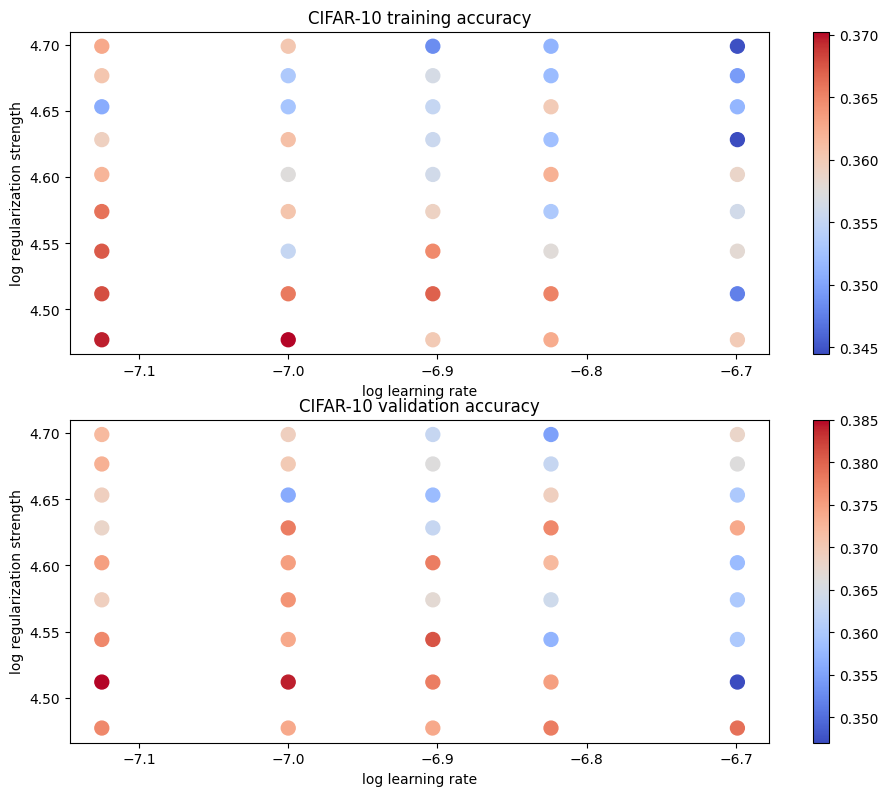

In [17]:
# 可视化交叉验证结果
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# 绘出训练集准确率
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# 绘出验证集准确率
colors = [results[x][1] for x in results] # 标记的默认大小为20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
# 评估测试集上的最佳svm
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.376000


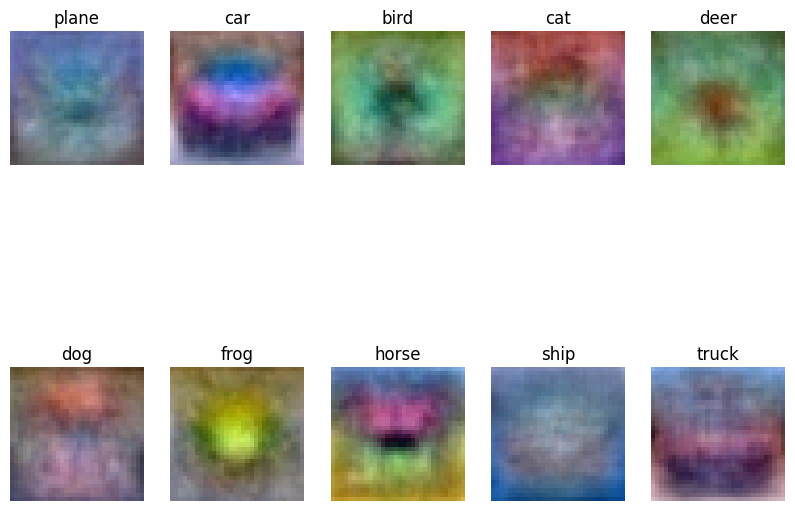

In [19]:
# 将每一类的学习权重可视化。
# 根据你对学习率和正则化强度的选择，这些可能很好看，也可能不好看。
w = best_svm.W[:-1,:] # 去掉偏差
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # 将权重重新缩放到0到255之间
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
